In [106]:
trial = 'Quebec'
isotope = '177Lu'
radiopharmaceutical = '177Lu - DOTATATE'
patient_id = '023N'
cycle = '1'

calculations_performed_by = 'Sara Kurkowska'
date = '29-11-2023' 
calculations_verified_by = ''

In [107]:
from quebec import getinputdata, getdosemapdata, intf2dcm
from patientdosimetry import PatientDosimetry
from mc import MonteCarlo
from dvk import DoseVoxelKernel
from olinda import Olinda
from dosemap_analysis import Dosemap
import pydicom
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
mimcsv, CT, SPECT, RT = getinputdata(patient_id, cycle)

          xdim  ydim  zdim   xsize   ysize   zsize
0  SPECT   128   128    81  4.7952  4.7952  4.7952
1     CT   128   128    81  4.7952  4.7952  4.7952
2     RT   128   128    81                        


In [177]:
import matplotlib.pyplot as plt

def image_visualisation(image, image2):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))    


    axs[0].imshow(image[:, :, 35])
    axs[0].set_title('Slice at index 50')
    
    axs[1].imshow(image[60, :, :].T)
    axs[1].set_title('Slice at index 100')
    
    axs[2].imshow(image[:, 40, :])
    axs[2].set_title('Slice at index 47')

    # Overlay the second image
    axs[0].imshow(image2[:, :, 35], alpha=0.5)  # adjust alpha for transparency
    axs[1].imshow(image2[60, :, :], alpha=0.2)  # adjust alpha for transparency
    axs[2].imshow(image2[:, 40, :], alpha=0.5)  # adjust alpha for transparency

    plt.tight_layout()
    plt.show()




In [178]:
CTNEW=CT
SPECTNEW=SPECT

In [184]:
print(CTNEW[60,:, :].shape)
print(SPECTNEW[60,:,:].shape)

(128, 81)
(128, 81)


In [179]:
print('CT')
print(CTNEW.shape)
#CTNEW = np.transpose(CT, (1,0,2))

print(CTNEW.shape)

print('SPECT')
print(SPECTNEW.shape)

CT
(128, 128, 81)
(128, 128, 81)
SPECT
(128, 128, 81)


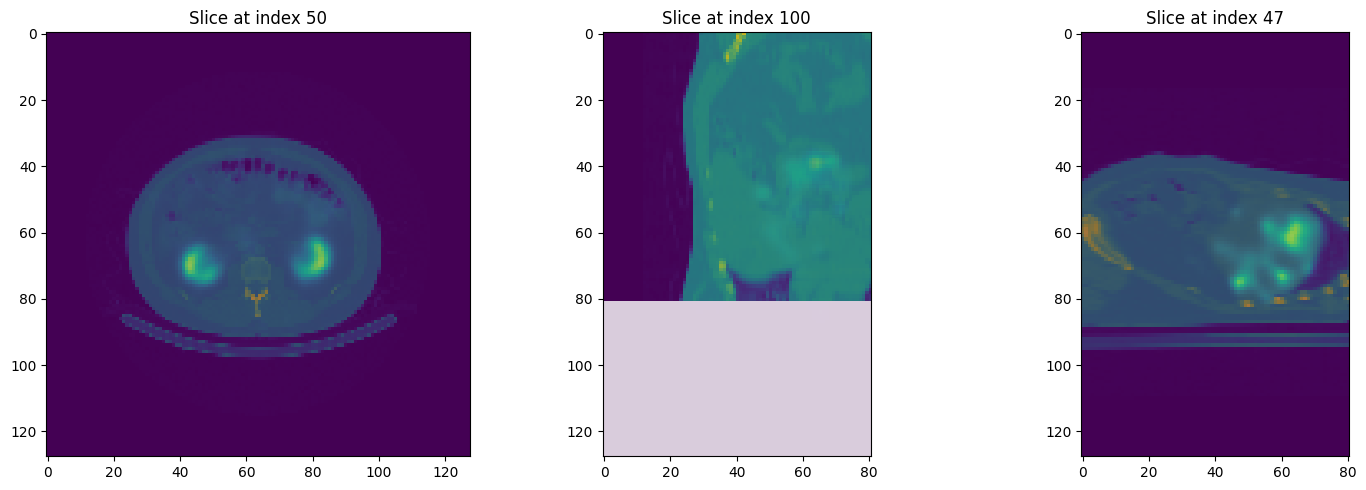

In [180]:
image_visualisation(CTNEW, SPECTNEW)

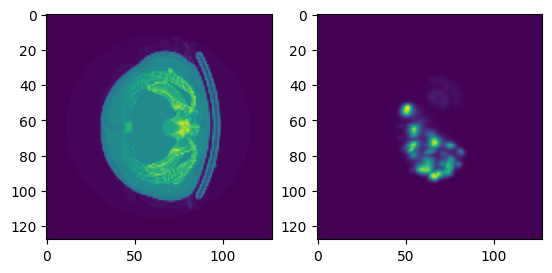

In [187]:
CTNEW_cor = np.max(CTNEW, axis=2)
SPECTNEW_cor = np.max(SPECTNEW, axis=2)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.rot90(CTNEW_cor))
ax[1].imshow(np.rot90(SPECTNEW_cor))

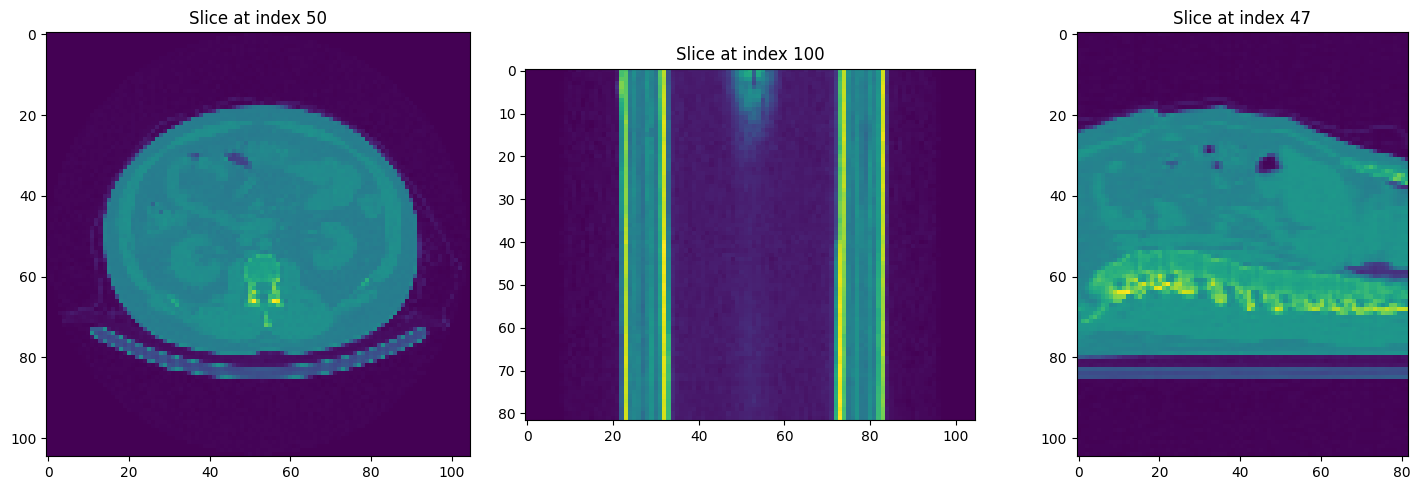

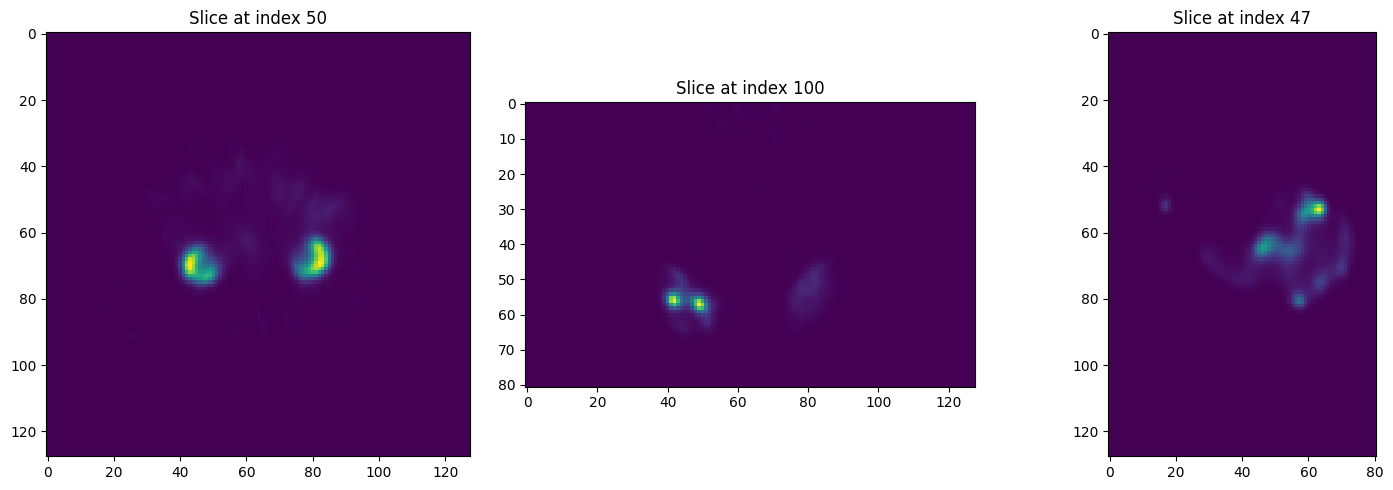

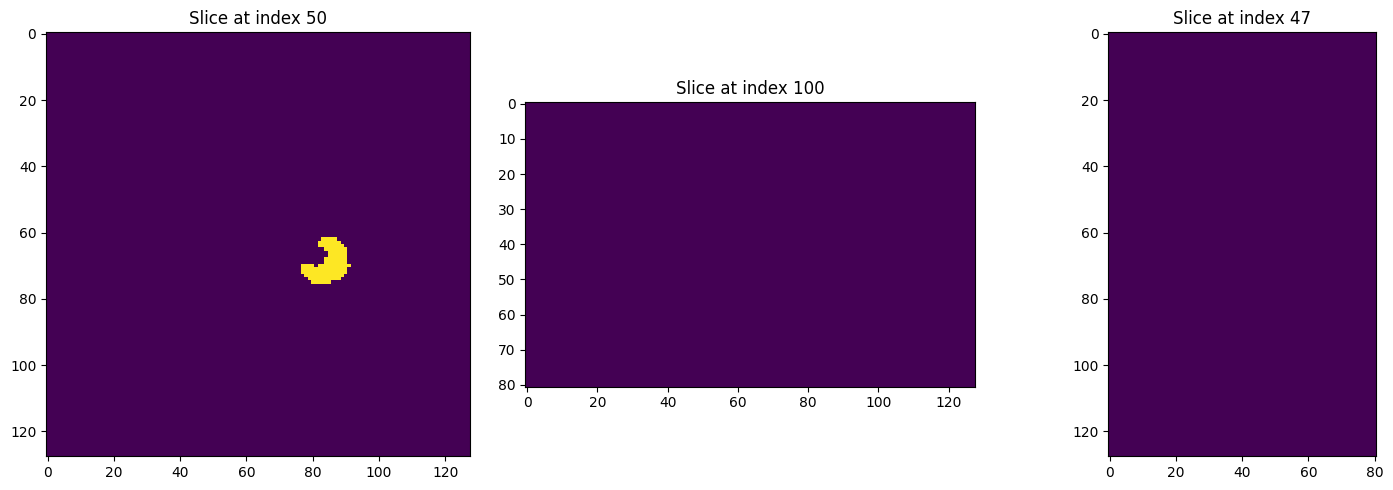

In [112]:
image_visualisation(CT, SPECT)
image_visualisation(SPECT)
image_visualisation(RT['LKindey'])

In [ ]:
N023_cycle01 = PatientDosimetry(patient_id, cycle, isotope, CT, SPECT, RT, mimcsv)

In [ ]:
organslist = N023_cycle01.dataframe()
organslist

AttributeError: 'numpy.ndarray' object has no attribute 'RadionuclideTotalDose'

In [102]:
method = 'Hanscheid'
df, lamda_eff_dict = N023_cycle01.fitting(method, injactivity)

here


AttributeError: 'PatientDosimetry' object has no attribute 'lamda_eff_dict'

In [ ]:
N023_cycle01.create_TIA()

In [ ]:
TIAMBqs = N023_cycle01.flip_images()

In [ ]:
N023_cycle01.normalise_TIA()

In [ ]:
N023_cycle01.save_images()

## Monte Carlo

In [ ]:
output_dir = f"/mnt/y/Sara/PR21_dosimetry/{patient_id}/cycle0{cycle}/MC"
N023_cycle01_MC = MonteCarlo(10, 1e9, output_dir)

In [ ]:
N023_cycle01_MC.split_simulations()

In [ ]:
N023_cycle01_MC.run_MC()

After the simulation is done, run the following line

In [ ]:
dosemap = getdosemapdata(patient_id, cycle)

## VSV Kernel

In [ ]:
N023_cycle01_DVK = DoseVoxelKernel(TIAMBqs, CT)

In [ ]:
N023_cycle01_DVK.kernel()

In [ ]:
dosemap_nonweighted = N023_cycle01_DVK.convolution()

In [ ]:
dosemap = N023_cycle01_DVK.weighting(dosemap_nonweighted)

## Olinda

In [ ]:
N023_cycle01_Olinda = Olinda(df, isotope)

In [ ]:
N023_cycle01_Olinda.phantom_data()

In [ ]:
# The Remainder value is automatically calculated from the total normalized number of disintegrations of the isotope (=Half-time[h]/ln(2)) minus the activity found in the organs (excluding the bladder)

In [ ]:
# In this population, trabecular bone – due to its lesser density when compared to cortical bone – provides only about 20% of the skeletal bone mass but it is responsible for most of the turnover [10,13].

In [ ]:
N023_cycle01_Olinda.create_case_file()

## Results

In [ ]:
N023_cycle01_dosemap = Dosemap(df, patient_id, cycle, dosemap, RT, organlist)

In [ ]:
#N023_cycle01_dosemap.image_visualisation(image_weighted)
#for organ in organlist:
#    N023_cycle01_dosemap.image_visualisation(RT[organ])

In [ ]:
N023_cycle01_dosemap.show_mean_statistics()

In [ ]:
N023_cycle01_dosemap.calculate_bed()

In [ ]:
N023_cycle01_dosemap.dose_volume_histogram()

In [ ]:
df.to_csv(f"/mnt/y/Sara/PR21_dosimetry/output/{patient_id}_cycle0{cycle}_dosimetry_output.csv")